In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trained-model-pth/trained_model.pth
/kaggle/input/images/04950.jpg
/kaggle/input/images/02610.jpg


In [2]:
from fastai.vision.all import *
import os
import csv
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch
from torch.utils.data import DataLoader
!pip install torch torchvision segmentation-models-pytorch


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.0 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Replace 'path_to_your_npy_file.npy' with the actual file path
array = np.load('/kaggle/working/images.npy')

# Now you can use 'array' as a normal NumPy array
print(array.shape)







(14999, 80, 160, 3)


#  Dataset

In [13]:
import numpy as np
from PIL import Image
from torchvision.transforms import Resize, ToTensor, Compose
from torch.utils.data import Dataset
import torch

class LaneDetectionDataset(Dataset):
    def __init__(self, images_npy, labels_npy, img_transform=None, label_transform=None):
        # Load image and label data from separate .npy files
        self.images = np.load(images_npy, allow_pickle=True)
        self.labels = np.load(labels_npy, allow_pickle=True)
        self.img_transform = img_transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Retrieve image and label arrays
        image_arr = self.images[idx]
        label_arr = self.labels[idx]

        # Convert numpy arrays to PIL images
        image = Image.fromarray(image_arr)

        # Convert label to grayscale PIL Image
        label = Image.fromarray(label_arr).convert('L') 

        # Apply transformations
        if self.img_transform:
            image = self.img_transform(image)
        if self.label_transform:
            label = self.label_transform(label)

        return image, label



label_transform = img_transform = Compose([
    Resize((96, 160)),
    ToTensor()
])




# Spliting Data

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the images and labels from their respective files
images = np.load('/kaggle/working/images.npy', allow_pickle=True)
labels = np.load('/kaggle/working/labels.npy', allow_pickle=True)


images_train, images_val, labels_train, labels_val = train_test_split(
    images, labels, test_size=0.2, random_state=42)

# Save the split datasets to new .npy files
np.save('images_train.npy', images_train)
np.save('images_val.npy', images_val)
np.save('labels_train.npy', labels_train)
np.save('labels_val.npy', labels_val)

print("Training and validation sets have been created and saved.")


Training and validation sets have been created and saved.


# Finding The Best Learning Rate

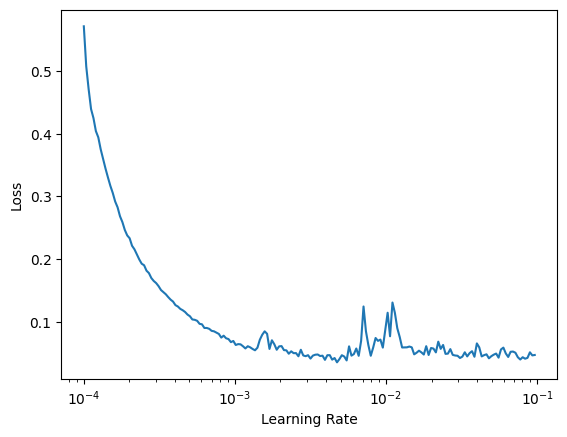

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
# Assuming 'model', 'train_loader', and 'criterion' are already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(
            encoder_name="resnet50",    # Use MobileNetV2 as encoder
            encoder_weights="imagenet",     # Pre-trained weights on ImageNet
            in_channels=3,                  # Number of input channels
            classes=1,                      # Number of output classes (binary mask)
        ).to(device)



train_dataset = LaneDetectionDataset('/kaggle/working/images_train.npy', '/kaggle/working/labels_train.npy', img_transform=img_transform, label_transform=label_transform)
val_dataset = LaneDetectionDataset('/kaggle/working/images_val.npy', '/kaggle/working/labels_val.npy', img_transform=img_transform, label_transform=label_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
criterion =  nn.BCEWithLogitsLoss()  

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Start with a small LR

# Initialize variables
lr_find_epochs = 2
lr_multiplier = (1e-1 / 1e-4) ** (1 / (lr_find_epochs * len(train_loader)))
current_lr = 1e-4
lrs = []
losses = []

model.train()
for epoch in range(lr_find_epochs):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Update LR
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
        current_lr *= lr_multiplier
        

        inputs=inputs.to(device)
        targets=targets.to(device)
        
        # Training step
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Record LR and loss
        lrs.append(optimizer.param_groups[0]['lr'])
        losses.append(loss.item())

# Plotting
plt.plot(lrs, losses)
plt.xscale('log')  # Use logarithmic scale for x-axis
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()



In [15]:
lrs[losses.index(min(losses))]



0.004737311198598112

# Finding the best batch size

# Training 

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp




# Define device: Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = LaneDetectionDataset('/kaggle/working/images_train.npy', '/kaggle/working/labels_train.npy', img_transform=img_transform, label_transform=label_transform,)
val_dataset = LaneDetectionDataset('/kaggle/working/images_val.npy', '/kaggle/working/labels_val.npy', img_transform=img_transform, label_transform=label_transform , )

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# # Initialize a U-Net model with a MobileNet encoder
model = smp.Unet(
    encoder_name="resnet50",    # Use MobileNetV2 as encoder
    encoder_weights="imagenet",     # Pre-trained weights on ImageNet
    in_channels=3,                  # Number of input channels
    classes=1,                      # Number of output classes (binary mask)
).to(device)



criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=lrs[losses.index(min(losses))])

# Training loop
num_epochs = 15  # Set this to a suitable value
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)  # Get raw logits from the model
        loss = criterion(outputs, labels)  # Calculate loss with raw logits

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    torch.save(model.state_dict(), f"{epoch+1}.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)  # Get raw logits from the model
            probabilities = torch.sigmoid(val_outputs)  # Convert logits to probabilities if needed

            val_loss += criterion(val_outputs, val_labels).item() * val_images.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")


print("Training Complete")


Epoch [1/15], Loss: 0.0971
Validation Loss: 0.0503
Epoch [2/15], Loss: 0.0376
Validation Loss: 0.1596
Epoch [3/15], Loss: 0.0352
Validation Loss: 0.0412
Epoch [4/15], Loss: 0.0293
Validation Loss: 0.0315
Epoch [5/15], Loss: 0.0276
Validation Loss: 0.0268
Epoch [6/15], Loss: 0.0254
Validation Loss: 0.0261
Epoch [7/15], Loss: 0.0236
Validation Loss: 0.0247
Epoch [8/15], Loss: 0.0224
Validation Loss: 0.0235
Epoch [9/15], Loss: 0.0217
Validation Loss: 0.0248
Epoch [10/15], Loss: 0.0215
Validation Loss: 0.0232
Epoch [11/15], Loss: 0.0212
Validation Loss: 0.0327
Epoch [12/15], Loss: 0.0202
Validation Loss: 0.0236
Epoch [13/15], Loss: 0.0193
Validation Loss: 0.0220
Epoch [14/15], Loss: 0.0190
Validation Loss: 0.0209
Epoch [15/15], Loss: 0.0189
Validation Loss: 0.0213
Training Complete


##### from IPython.display import FileLink

![](http://)# Provide the path to the saved model file
FileLink('trained_model3.pth')

In [17]:
FileLink('14.pth')

NameError: name 'FileLink' is not defined

##### from IPython.display import FileLink

# Provide the path to the saved model file
FileLink('trained_model3.pth')

In [ ]:
# Define the model architecture (same as during training)
import torch
import segmentation_models_pytorch as smp

# Define device: Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model
model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)



# Load the saved model weights
model.load_state_dict(torch.load('/kaggle/input/trained-model-pth/trained_model.pth'))
print(' ')


In [ ]:
import torchvision.transforms as transforms
from PIL import Image



# Load and preprocess test images
image1 = img_transform(Image.open('/kaggle/input/images/02610.jpg')).unsqueeze(0).to(device) 
image2 = img_transform(Image.open('/kaggle/input/images/04950.jpg')).unsqueeze(0).to(device) 


In [ ]:
# Perform inference on the test images
with torch.no_grad():
    output1 = torch.sigmoid(model(image1))
    output2 = model(image2)

# Process the model's output as needed
threshold = 0.5
print(output1)
output1_binary = (output1 > threshold).float().cpu().numpy()
output2_binary = (output2 > threshold).float().cpu().numpy()


In [ ]:
import matplotlib.pyplot as plt

# Display the first test image and its corresponding model output
plt.figure(figsize=(12, 6))

# Original test image
plt.subplot(1, 2, 1)
plt.title("Test Image 1")
plt.imshow(image1.squeeze().cpu().permute(1, 2, 0))  # Convert tensor to a numpy array

# Model's output (binary mask)
plt.subplot(1, 2, 2)
plt.title("Model Output 1")
plt.imshow(output1.squeeze().cpu())  

plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader


# Load the dataset
dataset = LaneDetectionDataset(images_npy='/kaggle/working/images.npy', labels_npy='/kaggle/working/labels.npy', 
                              img_transform=img_transform, label_transform=label_transform)

# Create a DataLoader
# For a single image, you can set batch_size to 1
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Process each image in the DataLoader
count=0
for img, label in loader:
    count+=1
    img = img.to(device)  # Move the image to the device (CPU or GPU)
    with torch.no_grad():
        output = model(img)  # Get the model's prediction
    plt.subplot(1, 2, 1)
    plt.imshow((output).squeeze().cpu())  # Convert tensor to a numpy array
    plt.subplot(1, 2, 2)
    plt.imshow((label).squeeze().cpu())  # Convert tensor to a numpy arr
    if count==3:
        break


In [ ]:
import matplotlib.pyplot as plt

def test_dataset(dataset, num_samples=5):
    # Create a DataLoader for testing with batch size 1
    test_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Iterate through the DataLoader and display a few examples
    for i, (image, label) in enumerate(test_loader):
        if i >= num_samples:
            break
        
        # Convert tensor to numpy array and transpose the image to (H, W, C) format
        image = image.squeeze().numpy().transpose(1, 2, 0)
        label = label.squeeze().numpy()

        # Display the image and label
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(label, cmap='gray')
        plt.title('Label')
        plt.axis('off')
        
        plt.show()

# Test the train_dataset
test_dataset(train_dataset, num_samples=5)

# Test the val_dataset
test_dataset(val_dataset, num_samples=5)


# Validation

In [ ]:
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}")


# Downloading Dataset

In [3]:
!pip install gdown

In [4]:
import gdown

url = 'https://drive.google.com/u/0/uc?id=1I264WVBL3Dyp_4PTfEYkVIDkg_Yn5gJJ&export=download'  # Replace with your shareable link
output = 'labels.npy'  # Replace with your desired output filename and extension
gdown.download(url, output, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1I264WVBL3Dyp_4PTfEYkVIDkg_Yn5gJJ&export=download
From (redirected): https://drive.google.com/uc?id=1I264WVBL3Dyp_4PTfEYkVIDkg_Yn5gJJ&export=download&confirm=t&uuid=4a0f71cc-27b5-482b-897e-47233d83003b
To: /kaggle/working/labels.npy
100%|██████████| 192M/192M [00:02<00:00, 81.8MB/s] 


'labels.npy'

In [5]:
import gdown

url = 'https://drive.google.com/u/0/uc?id=1S23Ac0_hbOktV0rE2q0IkQWpQjUfkMTB&export=download'  # Replace with your shareable link
output = 'images.npy'  # Replace with your desired output filename and extension
gdown.download(url, output, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1S23Ac0_hbOktV0rE2q0IkQWpQjUfkMTB&export=download
From (redirected): https://drive.google.com/uc?id=1S23Ac0_hbOktV0rE2q0IkQWpQjUfkMTB&export=download&confirm=t&uuid=df63532f-983a-431c-8994-7cc06a1aa144
To: /kaggle/working/images.npy
100%|██████████| 576M/576M [00:06<00:00, 90.0MB/s] 


'images.npy'

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor, Normalize, Compose



# Load the image
image_path = '/kaggle/input/images/04950.jpg'
plt.subplot(1, 2, 1)
image = Image.open(image_path)
image = img_transform(image).unsqueeze(0)  # Add a batch dimension
plt.imshow(image.cpu()[0][0])

# Move the image to the same device as the model
plt.subplot(1, 2, 2)
image = image.to(device)
model.eval()
with torch.no_grad():
    output = model(image)
    output = torch.sigmoid(output[0]).cpu()  # Apply sigmoid to convert output to probability
    plt.imshow(output[0])





In [ ]:
    val_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)  # Get raw logits from the model
            probabilities = torch.sigmoid(val_labels[0][0]).cpu()  # Convert logits to probabilities if needed
            plt.imshow(val_images[0][0].cpu())

    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")